In [2]:
import numpy as np
import matplotlib.pyplot as plt


In [3]:
## Import from local directory
import sys
sys.path.insert(0, './fnn')
from models import LSTMEmbedding, MLPEmbedding, ETDEmbedding, AMIEmbedding, TICAEmbedding


from regularizers import FNN



In [4]:

sol = np.loadtxt(r"E:\chaosgrandfinale\fnn-master\missed1.txt")
obs = sol # only first coordinate is observable
lstm_model = LSTMEmbedding(10, 
                     time_window=10, 
                     latent_regularizer=FNN(1),
                     random_state=0
                     )
coords_lstm = lstm_model.fit_transform(obs)
print("LSTM complete")


# MLP
mlp_model = MLPEmbedding(10, 
                     time_window=10, 
                     latent_regularizer=FNN(1), 
                     random_state=0
                     )
coords_mlp = mlp_model.fit_transform(obs, learning_rate=2e-4)
print("MLP complete")

# ICA
'''ica_model = TICAEmbedding(10, time_window=10, time_lag=0)
coords_ica = ica_model.fit_transform(obs)
print("ICA complete")'''
# Average Mutual Information
ami_model = AMIEmbedding(10, lag_cutoff=15)
coords_ami = ami_model.fit_transform(obs)



e:\os\envs\capstoneproject\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
e:\os\envs\capstoneproject\Lib\site-packages\keras\src\layers\regularization\gaussian_noise.py:29: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
LSTM complete


e:\os\envs\capstoneproject\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MLP complete


<Figure size 640x480 with 0 Axes>

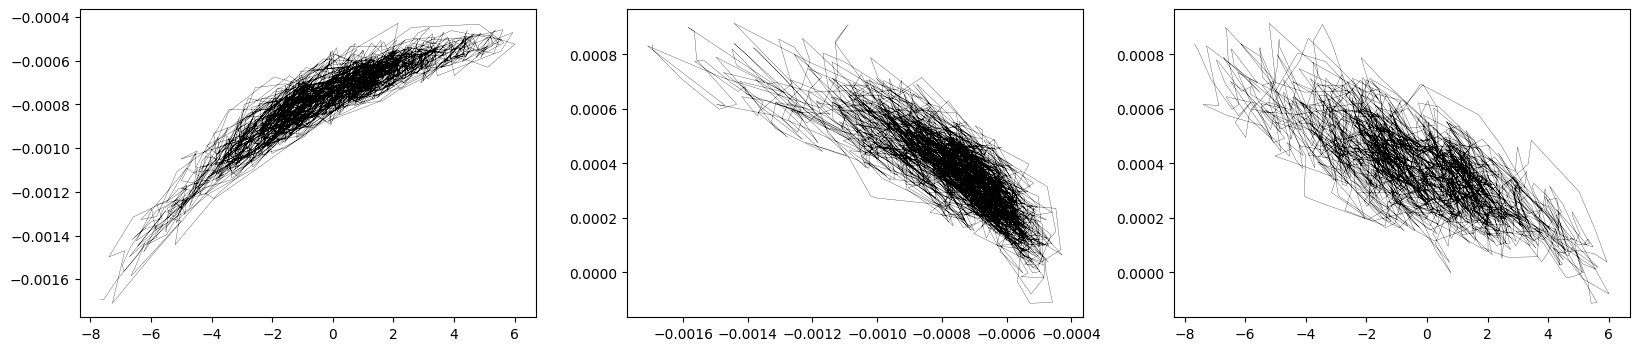

In [5]:


plt.figure()
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
ax[0].plot(coords_lstm[:,0], coords_lstm[:,1], 'k', linewidth=.2)
ax[1].plot(coords_lstm[:,1], coords_lstm[:,2], 'k', linewidth=.2)
ax[2].plot(coords_lstm[:,0], coords_lstm[:,2], 'k', linewidth=.2)

e:\os\envs\capstoneproject\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
e:\os\envs\capstoneproject\Lib\site-packages\keras\src\layers\regularization\gaussian_noise.py:29: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
LSTM training complete.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Forecast MSE: 113.49707586112883


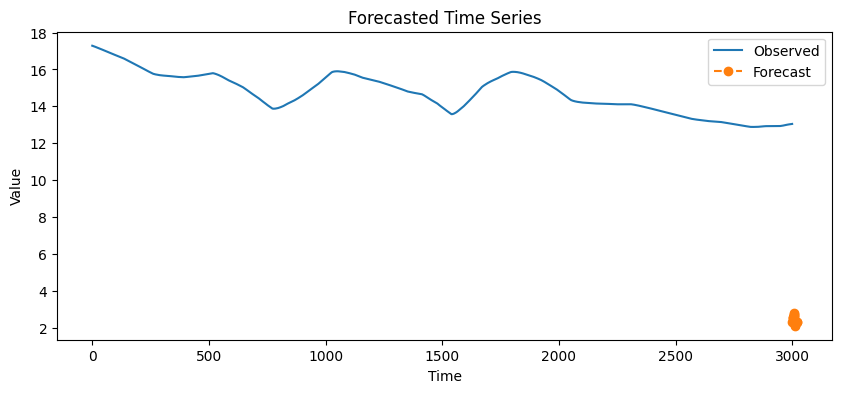

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# ----------------------------
# Define the forecasting function
# ----------------------------

def forecast(model, X, forecast_steps):
    """
    Forecast future time series values using a trained autoencoder model.

    Parameters
    ----------
    model : instance of LSTMEmbedding (or similar)
        The trained model.
    X : array-like, shape (n_timepoints,) or (n_timepoints, n_features)
        The observed time series.
    forecast_steps : int
        The number of future time steps to forecast.

    Returns
    -------
    forecast_window : np.ndarray, shape (forecast_steps, n_features)
        The forecasted future time series.
    """
    # Ensure forecast_steps is set
    if forecast_steps is None:
        forecast_steps = model.time_window

    # If X is 1-dimensional (e.g. univariate), reshape to 2D: (n_timepoints, 1)
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    
    # Get the last available window from X
    last_window = X[-model.time_window:]
    # Add the batch dimension: shape (1, time_window, n_features)
    current_window = last_window.reshape(1, model.time_window, -1)
    
    # Prepare to store forecasted values
    forecast_list = []
    steps_forecasted = 0
    while steps_forecasted < forecast_steps:
        # Get the latent representation from the encoder
        latent = model.model.encoder.predict(current_window)
        # Decode to obtain the forecast (which typically covers a full window)
        pred = model.model.decoder.predict(latent)
        pred = pred.squeeze(axis=0)  # shape: (model.time_window, n_features)
        
        # Determine how many steps to take from this forecast
        steps_to_take = min(model.time_window, forecast_steps - steps_forecasted)
        forecast_list.append(pred[:steps_to_take])
        steps_forecasted += steps_to_take
        
        # Update the current window by removing the oldest steps and appending the new forecasted ones.
        current_window_np = current_window.squeeze(axis=0)
        current_window_np = np.concatenate([current_window_np[steps_to_take:], pred[:steps_to_take]], axis=0)
        current_window = current_window_np.reshape(1, model.time_window, -1)
        
    forecast_window = np.concatenate(forecast_list, axis=0)
    return forecast_window

# ----------------------------
# Load your data and train the model
# ----------------------------

# Load the full time series (for example, a univariate series)
sol = np.loadtxt(r"E:\chaospaper\fnn-master\missed1.txt")
# Use the first 3000 time points for training and embedding.
obs = sol[:3000]

# Initialize and train the LSTMEmbedding model.
lstm_model = LSTMEmbedding(
    10, 
    time_window=10, 
    latent_regularizer=FNN(1),
    random_state=0
)
coords_lstm = lstm_model.fit_transform(obs)
print("LSTM training complete.")

# ----------------------------
# Forecasting and MSE Calculation
# ----------------------------

# Specify externally the number of forecasted values you want.
num_forecast_steps = 20

# Compute the forecast based on the last window of observations.
predicted_forecast = forecast(lstm_model, obs, num_forecast_steps)
# If the forecast returns shape (num_forecast_steps, 1) (for univariate data), squeeze it to 1D.
predicted_forecast = predicted_forecast.squeeze()

# For MSE, we need the ground truth for the forecasted period.
# Here we assume that the ground truth values are stored immediately after the training data.
true_forecast = sol[3000:3000 + num_forecast_steps]

# Calculate the Mean Squared Error (MSE)
mse = np.mean((predicted_forecast - true_forecast) ** 2)
print("Forecast MSE:", mse)

# ----------------------------
# Plot the observed data and the forecasted values
# ----------------------------

plt.figure(figsize=(10, 4))
# Plot all observed data
plt.plot(np.arange(len(obs)), obs, label="Observed")
# Plot the forecasted segment (shifted in time)
plt.plot(np.arange(len(obs), len(obs) + len(predicted_forecast)), 
         predicted_forecast, 
         label="Forecast", linestyle="--", marker="o")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Forecasted Time Series")
plt.legend()
plt.show()
